<a href="https://colab.research.google.com/github/Dolce-Latte/dnclab_study/blob/main/Googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn # 신경망들이 포함됨
import torch.optim as optim # 최적화 알고리즘들이 포함됨
import torch.nn.init as init # 텐서에 초기값을 줌
import torch.nn.functional as F

import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴

import numpy as np
import matplotlib.pyplot as plt

# Transform 정의
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train data transform
transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# test data transform
transform_test = transforms.Compose([
        transforms.Resize(224),     
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])



# CIFAR10 TRAIN 데이터 정의
cifar10_train = datasets.CIFAR10(root="../Data/", train=True, transform=transform_train, target_transform=None, download=True)

# CIFAR10 TEST 데이터 정의
cifar10_test = datasets.CIFAR10(root="../Data/", train=False, transform=transform_test, target_transform=None, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../Data/cifar-10-python.tar.gz to ../Data/
Files already downloaded and verified


In [ ]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 20

train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

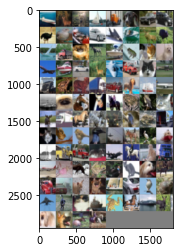

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
def conv_1(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

In [ ]:
def conv_1_3(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,3,1,1),
        nn.ReLU()
    )
    return model

In [ ]:
def conv_1_5(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,5,1,2),
        nn.ReLU()
    )
    return model

In [ ]:
def max_3_1(in_dim,out_dim):
    model = nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

In [ ]:
class inception_module(nn.Module):
    def __init__(self,in_dim,out_dim_1,mid_dim_3,out_dim_3,mid_dim_5,out_dim_5,pool_dim):
        super(inception_module,self).__init__()
        # 1x1 Convolution
        self.conv_1 = conv_1(in_dim,out_dim_1)
        
        # 1x1 Convolution -> 3x3 Convolution
        self.conv_1_3 = conv_1_3(in_dim,mid_dim_3,out_dim_3)
        
        # 1x1 Convolution -> 5x5 Convolution
        self.conv_1_5 = conv_1_5(in_dim,mid_dim_5,out_dim_5)
        
        # 3x3 MaxPooling -> 1x1 Convolution
        self.max_3_1 = max_3_1(in_dim,pool_dim)

    def forward(self,x):
        out_1 = self.conv_1(x)
        out_2 = self.conv_1_3(x)
        out_3 = self.conv_1_5(x)
        out_4 = self.max_3_1(x)
        # concat
        output = torch.cat([out_1,out_2,out_3,out_4],1)
        return output

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, base_dim, num_classes=1000):
        super(GoogLeNet, self).__init__()
        self.num_classes=num_classes
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3),
            nn.MaxPool2d(3,2,1),
            nn.Conv2d(base_dim,base_dim*3,3,1,1),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            inception_module(base_dim*3,64,96,128,16,32,32),
            inception_module(base_dim*4,128,128,192,32,96,64),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_3 = nn.Sequential(
            inception_module(480,192,96,208,16,48,64),
            inception_module(512,160,112,224,24,64,64),
            inception_module(512,128,128,256,24,64,64),
            inception_module(512,112,144,288,32,64,64),
            inception_module(528,256,160,320,32,128,128),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_4 = nn.Sequential(
            inception_module(832,256,160,320,32,128,128),
            inception_module(832,384,192,384,48,128,128), 
            nn.AvgPool2d(7,1),
        )
        self.layer_5 = nn.Dropout2d(0.4)
        self.fc_layer = nn.Linear(1024,self.num_classes)
                
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

In [ ]:
# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Googlenet 클래스를 인스턴스화
model = GoogLeNet(base_dim=64).to(device)

# 손실함수 및 최적화함수 설정|
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import torch.optim as optim

gpu_model = model


for epoch in range(num_epoch):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to('cuda'), data[1].to('cuda')

        optimizer.zero_grad()

        gpu_model = gpu_model.to('cuda')
        outputs = gpu_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        # epoch, num_epoch, i+1, len(train_loader),
        # loss.item()))
        running_loss += loss.item()
        if i % 50 == 49:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
print('Finished Training')

[1,    50] loss: 0.116
[1,   100] loss: 0.116
[1,   150] loss: 0.116
[1,   200] loss: 0.109
[1,   250] loss: 0.105
[1,   300] loss: 0.102
[1,   350] loss: 0.098
[1,   400] loss: 0.094
[1,   450] loss: 0.091
[1,   500] loss: 0.091
[2,    50] loss: 0.088
[2,   100] loss: 0.087
[2,   150] loss: 0.086
[2,   200] loss: 0.083
[2,   250] loss: 0.083
[2,   300] loss: 0.081
[2,   350] loss: 0.079
[2,   400] loss: 0.078
[2,   450] loss: 0.077
[2,   500] loss: 0.076
[3,    50] loss: 0.074
[3,   100] loss: 0.074
[3,   150] loss: 0.071
[3,   200] loss: 0.069
[3,   250] loss: 0.070
[3,   300] loss: 0.067
[3,   350] loss: 0.066
[3,   400] loss: 0.065
[3,   450] loss: 0.064
[3,   500] loss: 0.062
[4,    50] loss: 0.063
[4,   100] loss: 0.062
[4,   150] loss: 0.060
[4,   200] loss: 0.061
[4,   250] loss: 0.060
[4,   300] loss: 0.058
[4,   350] loss: 0.059
[4,   400] loss: 0.059
[4,   450] loss: 0.056
[4,   500] loss: 0.056
[5,    50] loss: 0.056
[5,   100] loss: 0.055
[5,   150] loss: 0.054
[5,   200] 

In [ ]:
correct = 0
total = 0


for data in test_loader:
    images, labels = data[0].to('cuda'), data[1].to('cuda')
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
    gpu_model = gpu_model.to('cuda')
    outputs = gpu_model(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 73 %


In [ ]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

for data in test_loader:
    images, labels = data[0].to('cuda'), data[1].to('cuda')

    gpu_model = gpu_model.to('cuda')
    outputs = gpu_model(images)
    _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 86.6 %
Accuracy for class: car   is 95.3 %
Accuracy for class: bird  is 53.4 %
Accuracy for class: cat   is 46.1 %
Accuracy for class: deer  is 61.1 %
Accuracy for class: dog   is 69.0 %
Accuracy for class: frog  is 81.1 %
Accuracy for class: horse is 83.7 %
Accuracy for class: ship  is 71.6 %
Accuracy for class: truck is 83.1 %
